In [7]:
import os
import numpy as np
import librosa
import pickle
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm import tqdm
import pandas as pd

# Define paths
base_path = 'E:\\Queenless\\20k_audio_splitted_dataset'
output_dir = 'E:\\Queenless\\Features_data1'
feature_file = os.path.join(output_dir, 'all_features.pkl')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Sample audio files for testing
audio_path_nonqueen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\NonQueen\\queenless_1.wav'
audio_path_queen = 'E:\\Queenless\\20k_audio_splitted_dataset\\test\\Queen\\queen_1.wav'

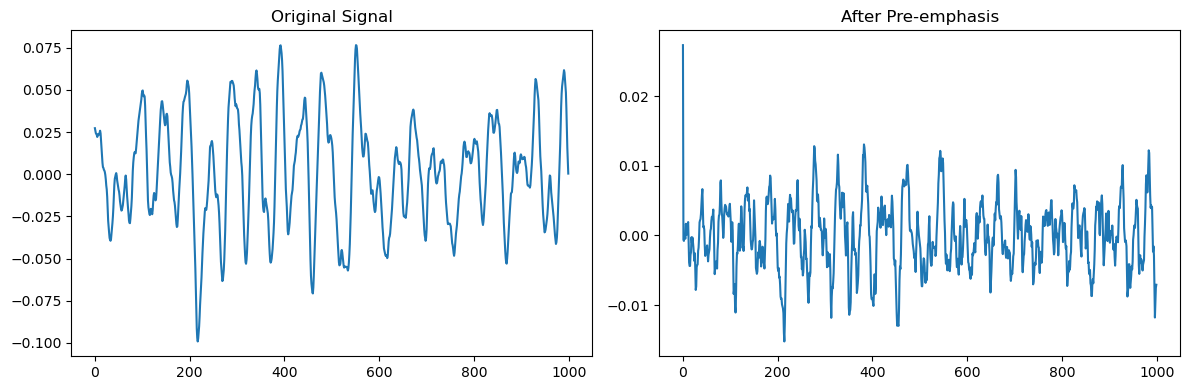

In [ ]:
def load_and_visualize_audio(file_path):
    """
    Load audio file and display waveform and spectrum
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Get file name for display
    file_name = os.path.basename(file_path)
    
    # Plot waveform and spectrum
    plt.figure(figsize=(12, 6))
    
    # Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {file_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Spectrum
    plt.subplot(2, 1, 2)
    D = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                           y_axis='log', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Power spectrogram')
    
    plt.tight_layout()
    plt.show()
    
    return y, sr

# Test function
y_nonqueen, sr_nonqueen = load_and_visualize_audio(audio_path_nonqueen)
y_queen, sr_queen = load_and_visualize_audio(audio_path_queen)

print(f"NonQueen audio: {len(y_nonqueen)} samples, {sr_nonqueen} Hz")
print(f"Queen audio: {len(y_queen)} samples, {sr_queen} Hz")

Signal shape: (32000,), Frames shape: (199, 400)
Number of frames: 199, Frame length: 400


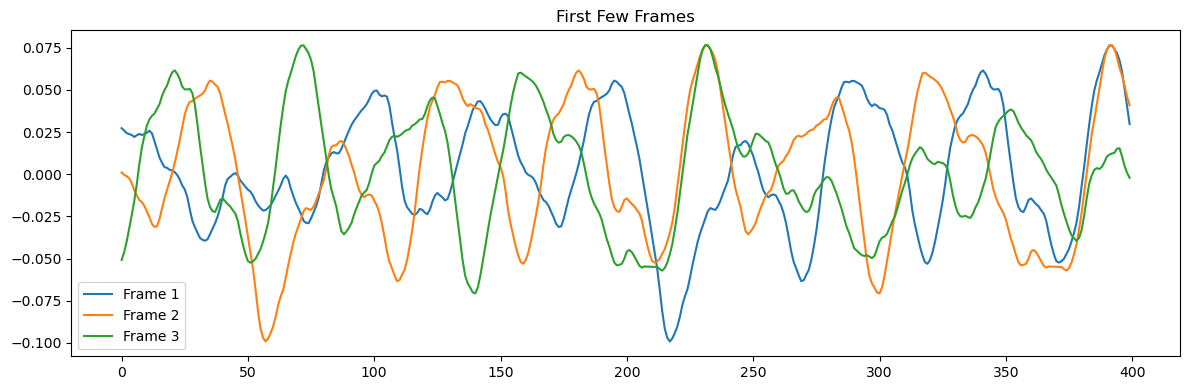

In [9]:
def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

# Test framing
signal, sr = librosa.load(audio_path_nonqueen, sr=None)
frames = framing(signal, sr)
print(f"Signal shape: {signal.shape}, Frames shape: {frames.shape}")
print(f"Number of frames: {frames.shape[0]}, Frame length: {frames.shape[1]}")

# Visualize a few frames
plt.figure(figsize=(12, 4))
for i in range(min(3, frames.shape[0])):
    plt.plot(frames[i], label=f'Frame {i+1}')
plt.legend()
plt.title('First Few Frames')
plt.tight_layout()
plt.show()

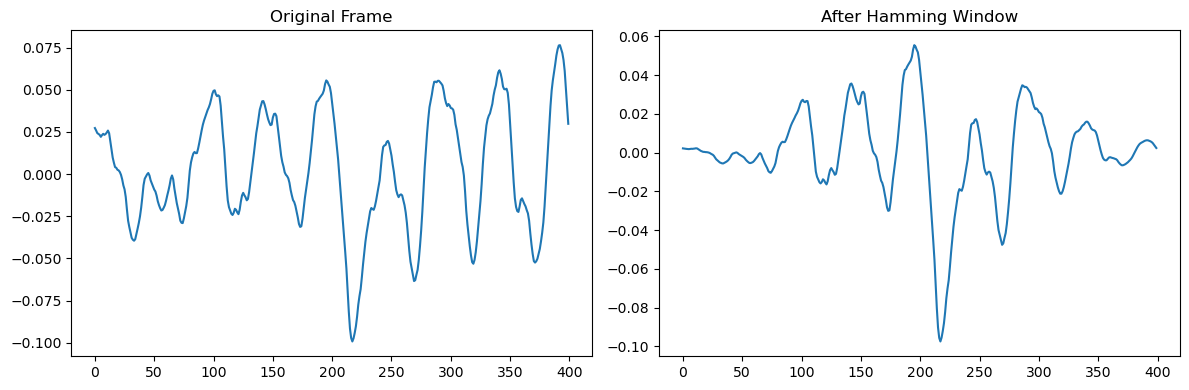

In [10]:
def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

# Test windowing
signal, sr = librosa.load(audio_path_nonqueen, sr=None)
frames = framing(signal, sr)
windowed = windowing(frames)

# Visualize windowing effect
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(frames[0])
plt.title('Original Frame')
plt.subplot(1, 2, 2)
plt.plot(windowed[0])
plt.title('After Hamming Window')
plt.tight_layout()
plt.show()

Magnitudes shape: (199, 257)


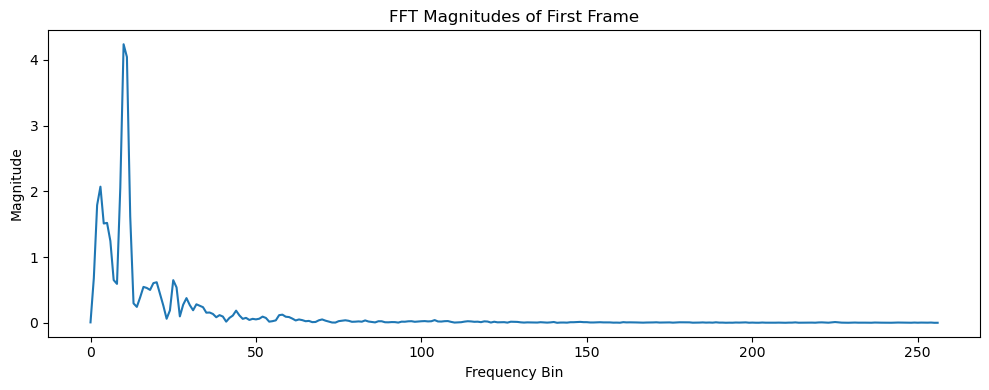

In [11]:
def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

# Test FFT
signal, sr = librosa.load(audio_path_nonqueen, sr=None)
frames = framing(signal, sr)
windowed = windowing(frames)
magnitudes = fft_frames(windowed)

print(f"Magnitudes shape: {magnitudes.shape}")

# Visualize FFT of a frame
plt.figure(figsize=(10, 4))
plt.plot(magnitudes[0])
plt.title('FFT Magnitudes of First Frame')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

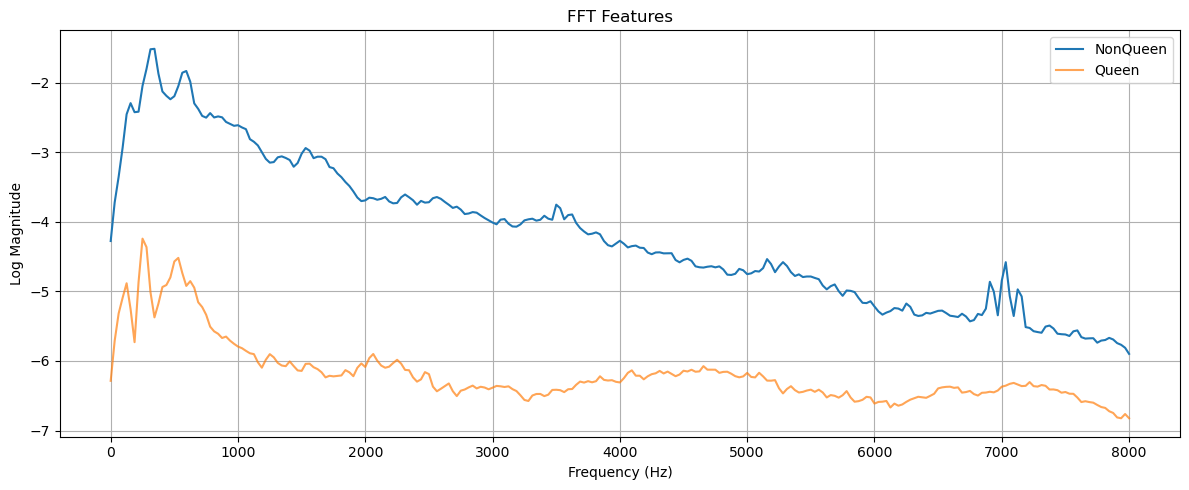

In [12]:
def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
      
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    return fft_feature

# Test complete FFT extraction
signal_nonqueen, sr_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, sr_queen = librosa.load(audio_path_queen, sr=None)

fft_nonqueen = compute_fft_features(signal_nonqueen, sr_nonqueen)
fft_queen = compute_fft_features(signal_queen, sr_queen)

# Plot comparison
freq_bins = np.linspace(0, sr_nonqueen/2, len(fft_nonqueen))
plt.figure(figsize=(12, 5))
plt.plot(freq_bins, fft_nonqueen, label='NonQueen')
plt.plot(freq_bins, fft_queen, label='Queen', alpha=0.7)
plt.title('FFT Features')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

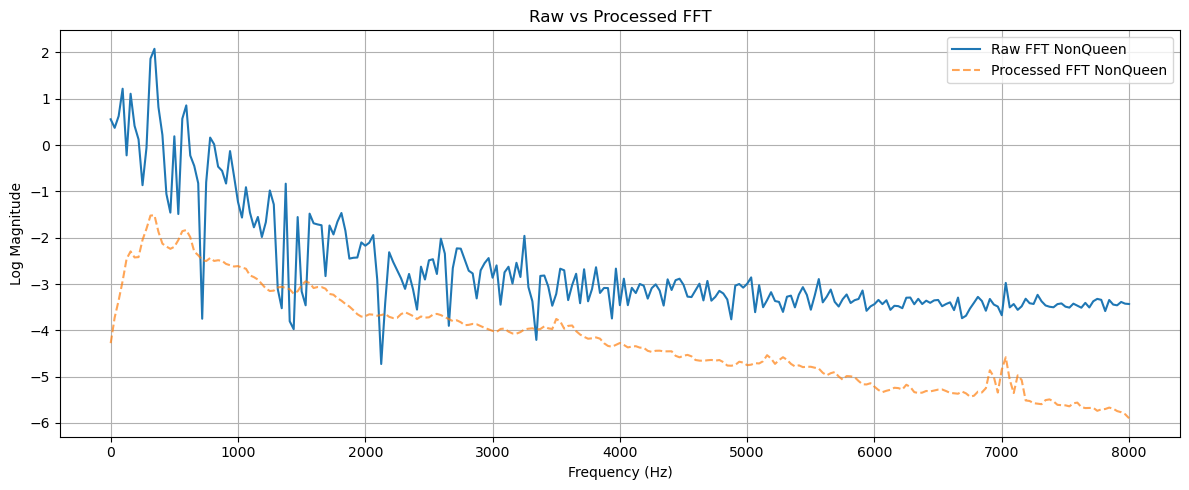

In [13]:
def compute_raw_fft(signal_in, NFFT=512, apply_log=True):
    """
    Tính toán FFT trực tiếp từ tín hiệu gốc không qua tiền xử lý
    """
    fft_result = np.fft.rfft(signal_in, NFFT)
    magnitude = np.absolute(fft_result)
    
    if apply_log:
        return np.log(magnitude + 1e-8)
    else:
        return magnitude

# Test raw FFT
signal_nonqueen, sr_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, sr_queen = librosa.load(audio_path_queen, sr=None)

raw_fft_nonqueen = compute_raw_fft(signal_nonqueen)
raw_fft_queen = compute_raw_fft(signal_queen)

# Compare raw FFT with processed FFT
freq_bins = np.linspace(0, sr_nonqueen/2, len(raw_fft_nonqueen))
plt.figure(figsize=(12, 5))
plt.plot(freq_bins, raw_fft_nonqueen, label='Raw FFT NonQueen')
plt.plot(freq_bins, compute_fft_features(signal_nonqueen, sr_nonqueen), 
         label='Processed FFT NonQueen', linestyle='--', alpha=0.7)
plt.title('Raw vs Processed FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

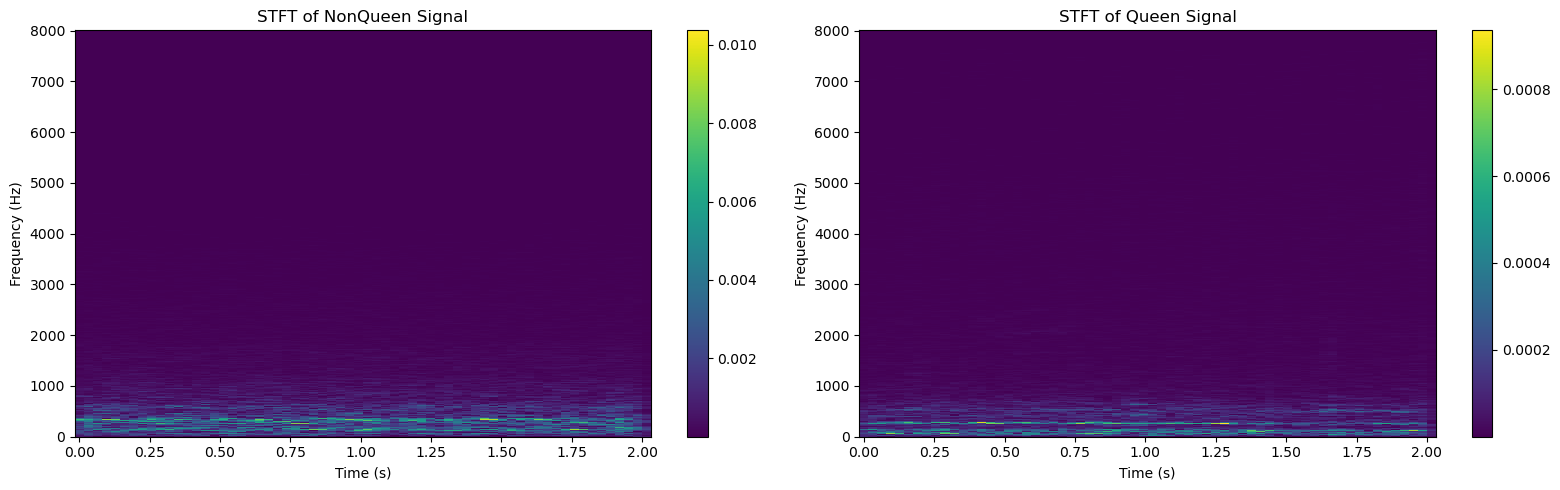

In [14]:
def compute_stft(signal_in, sample_rate, window_size=2048, hop_size=512, window_type='hann'):
    """
    Hàm tính Short-Time Fourier Transform (STFT) của tín hiệu âm thanh.
    """
    window = get_window(window_type, window_size)
    f, t, Zxx = stft(signal_in, fs=sample_rate, window=window, 
                    nperseg=window_size, noverlap=window_size-hop_size)
    return f, t, Zxx

# Test STFT
signal_nonqueen, sr_nonqueen = librosa.load(audio_path_nonqueen, sr=None)
signal_queen, sr_queen = librosa.load(audio_path_queen, sr=None)

f_nonqueen, t_nonqueen, Zxx_nonqueen = compute_stft(signal_nonqueen, sr_nonqueen)
f_queen, t_queen, Zxx_queen = compute_stft(signal_queen, sr_queen)

# Plot STFT spectrograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

cax1 = ax1.pcolormesh(t_nonqueen, f_nonqueen, np.abs(Zxx_nonqueen), shading='auto')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('STFT of NonQueen Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')

cax2 = ax2.pcolormesh(t_queen, f_queen, np.abs(Zxx_queen), shading='auto')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('STFT of Queen Signal')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
with open("feature.pkl", "rb") as f:
    pickle.load(f)